**Get dependencies installed and imported**

In [ ]:
! pip3 install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn import tree
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import neighbors, datasets
plt.style.use('seaborn')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

     |████████████████████████████████| 81kB 4.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Set up seed

In [ ]:
seed = 80
np.random.seed(seed)

pd.options.mode.chained_assignment = None

**Download the Dataset**

In [ ]:
! wget "https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv"
! wget "https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv"

--2020-12-20 18:20:12--  https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv
Resolving www.unsw.adfa.edu.au (www.unsw.adfa.edu.au)... 202.58.60.197
Connecting to www.unsw.adfa.edu.au (www.unsw.adfa.edu.au)|202.58.60.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32293018 (31M) [text/csv]
Saving to: ‘UNSW_NB15_training-set.csv’

UNSW_NB15_training- 100%[===================>]  30.80M   383KB/s    in 1m 45s  

2020-12-20 18:21:58 (300 KB/s) - ‘UNSW_NB15_training-set.csv’ saved [32293018/32293018]

--2020-12-20 18:21:58--  https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv
Resolving www.unsw.adfa.edu.au (www.unsw.adfa.edu.au)... 202.58.60.197
Connecting to www.unsw.adfa.edu.au (www.unsw.adfa.edu.au)|202.58.60.197|:443... connected.
HTTP request sent, awai

In [ ]:

trainSet = pd.read_csv('UNSW_NB15_training-set.csv')
testSet = pd.read_csv('UNSW_NB15_testing-set.csv')

print("Dataset Info:")
print(trainSet.info())
print("Dataset:")
print(trainSet)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  i

Helper Functions

In [ ]:
def get_data(dtype="binary"):
    
    trainData = trainSet.copy(deep=True)
    testData = testSet.copy(deep=True)
    if (dtype=="multi"):
        dic = {'Normal':0, 'Backdoor':1, 'Analysis':2, 'Fuzzers':3, 'Shellcode':4, 'Reconnaissance':5, 'Exploits':6, 'DoS':7, 'Worms':8, 'Generic':9}
        
        trainData['attack_cat'] = trainData['attack_cat'].map(dic)
        testData['attack_cat'] = testData['attack_cat'].map(dic)

    return trainData, testData

def get_categoryEncodedData(trainX, testX, categorical_feat,y):
    encoder = TargetEncoder()

    trainX.loc[ :, categorical_feat] = encoder.fit_transform(trainX.loc[:,categorical_feat].copy(deep=True), y)

    testX.loc[: , categorical_feat] = encoder.transform(testX.loc[:,categorical_feat].copy())
    return

def get_undersampling(trainX, trainY, strategy = "random"):
    if (strategy == "tomek"):
        undersample = TomekLinks(random_state = seed)
    else: 
        undersample = RandomUnderSampler(random_state=seed)
    trainX, trainY = undersample.fit_resample(trainX, trainY)
    
    return trainX, trainY

def min_max_scaling(trainX, testX):
    scaler = MinMaxScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)
    return trainX, testX

numerical_feat = ["dur" , "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss",  "sload", "dload", "spkts", "dpkts", "swin", "dwin", "smean", "dmean", "trans_depth", "response_body_len", "sjit", "djit", "sinpkt" , "dinpkt", "tcprtt", "synack", "ackdat", "ct_state_ttl", "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm","ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "rate"]

categorical_feat = ["proto", "state", "service", "is_sm_ips_ports", "is_ftp_login"]


**Data Visualisation**

Text(0.5, 0.9, 'Attack Category Distribution')

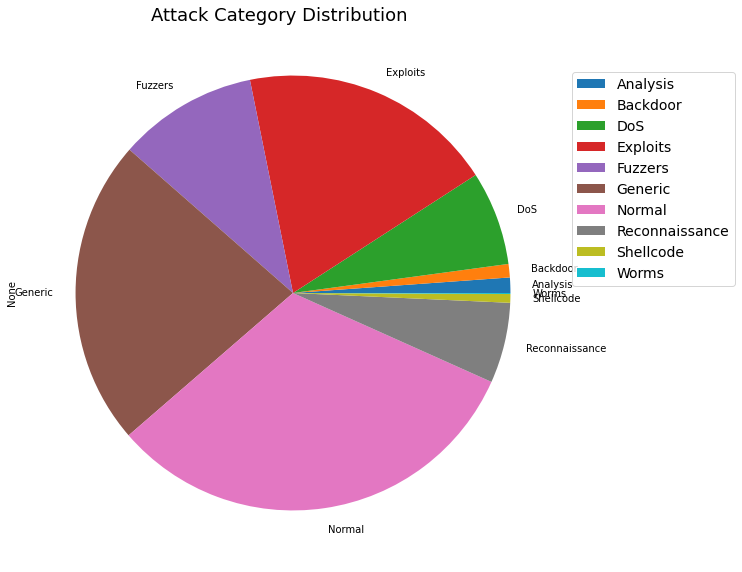

In [ ]:
trainSet.groupby('attack_cat').size().plot(kind='pie', figsize = (15,10))
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left", fontsize=14,)
plt.suptitle("Attack Category Distribution", fontsize=18, y = 0.9) # Add the text/suptitle to figure


###Binary Classification

Decision Tree Classifier


In [ ]:

trainData, testData = get_data()

trainX = trainData[numerical_feat+categorical_feat]
testX = testData[numerical_feat + categorical_feat]
trainY = trainSet[['label']]
testY = testSet[['label']]

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, trainY = get_undersampling(trainX, trainY)

trainX, testX = min_max_scaling(trainX, testX)

binDT = DecisionTreeClassifier(max_depth=20, ccp_alpha = 0.0008, random_state=seed)

binDT.fit(trainX, trainY)
yhat = binDT.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))

print(classification_report(testY, yhat))

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy on Test Set: 0.9209056017101491
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     37000
           1       0.91      0.95      0.93     45332

    accuracy                           0.92     82332
   macro avg       0.92      0.92      0.92     82332
weighted avg       0.92      0.92      0.92     82332



Decision Tree Visualisation

[Text(456.05769230769226, 1540.2, 'X[3] <= 0.239\ngini = 0.5\nsamples = 112000\nvalue = [56000, 56000]\nclass = Normal'),
 Text(171.69230769230768, 1359.0, 'X[35] <= 0.988\ngini = 0.007\nsamples = 42527\nvalue = [42386, 141]\nclass = Normal'),
 Text(85.84615384615384, 1177.8, 'gini = 0.0\nsamples = 42386\nvalue = [42386, 0]\nclass = Normal'),
 Text(257.53846153846155, 1177.8, 'gini = 0.0\nsamples = 141\nvalue = [0, 141]\nclass = Intrusion'),
 Text(740.4230769230769, 1359.0, 'X[1] <= 0.0\ngini = 0.315\nsamples = 69473\nvalue = [13614, 55859]\nclass = Intrusion'),
 Text(429.23076923076917, 1177.8, 'X[13] <= 0.018\ngini = 0.099\nsamples = 35010\nvalue = [1837, 33173]\nclass = Intrusion'),
 Text(343.38461538461536, 996.6, 'X[5] <= 0.0\ngini = 0.477\nsamples = 2902\nvalue = [1764, 1138]\nclass = Normal'),
 Text(257.53846153846155, 815.4, 'X[28] <= 0.074\ngini = 0.5\nsamples = 2288\nvalue = [1154, 1134]\nclass = Normal'),
 Text(171.69230769230768, 634.2, 'gini = 0.458\nsamples = 1221\nvalue 

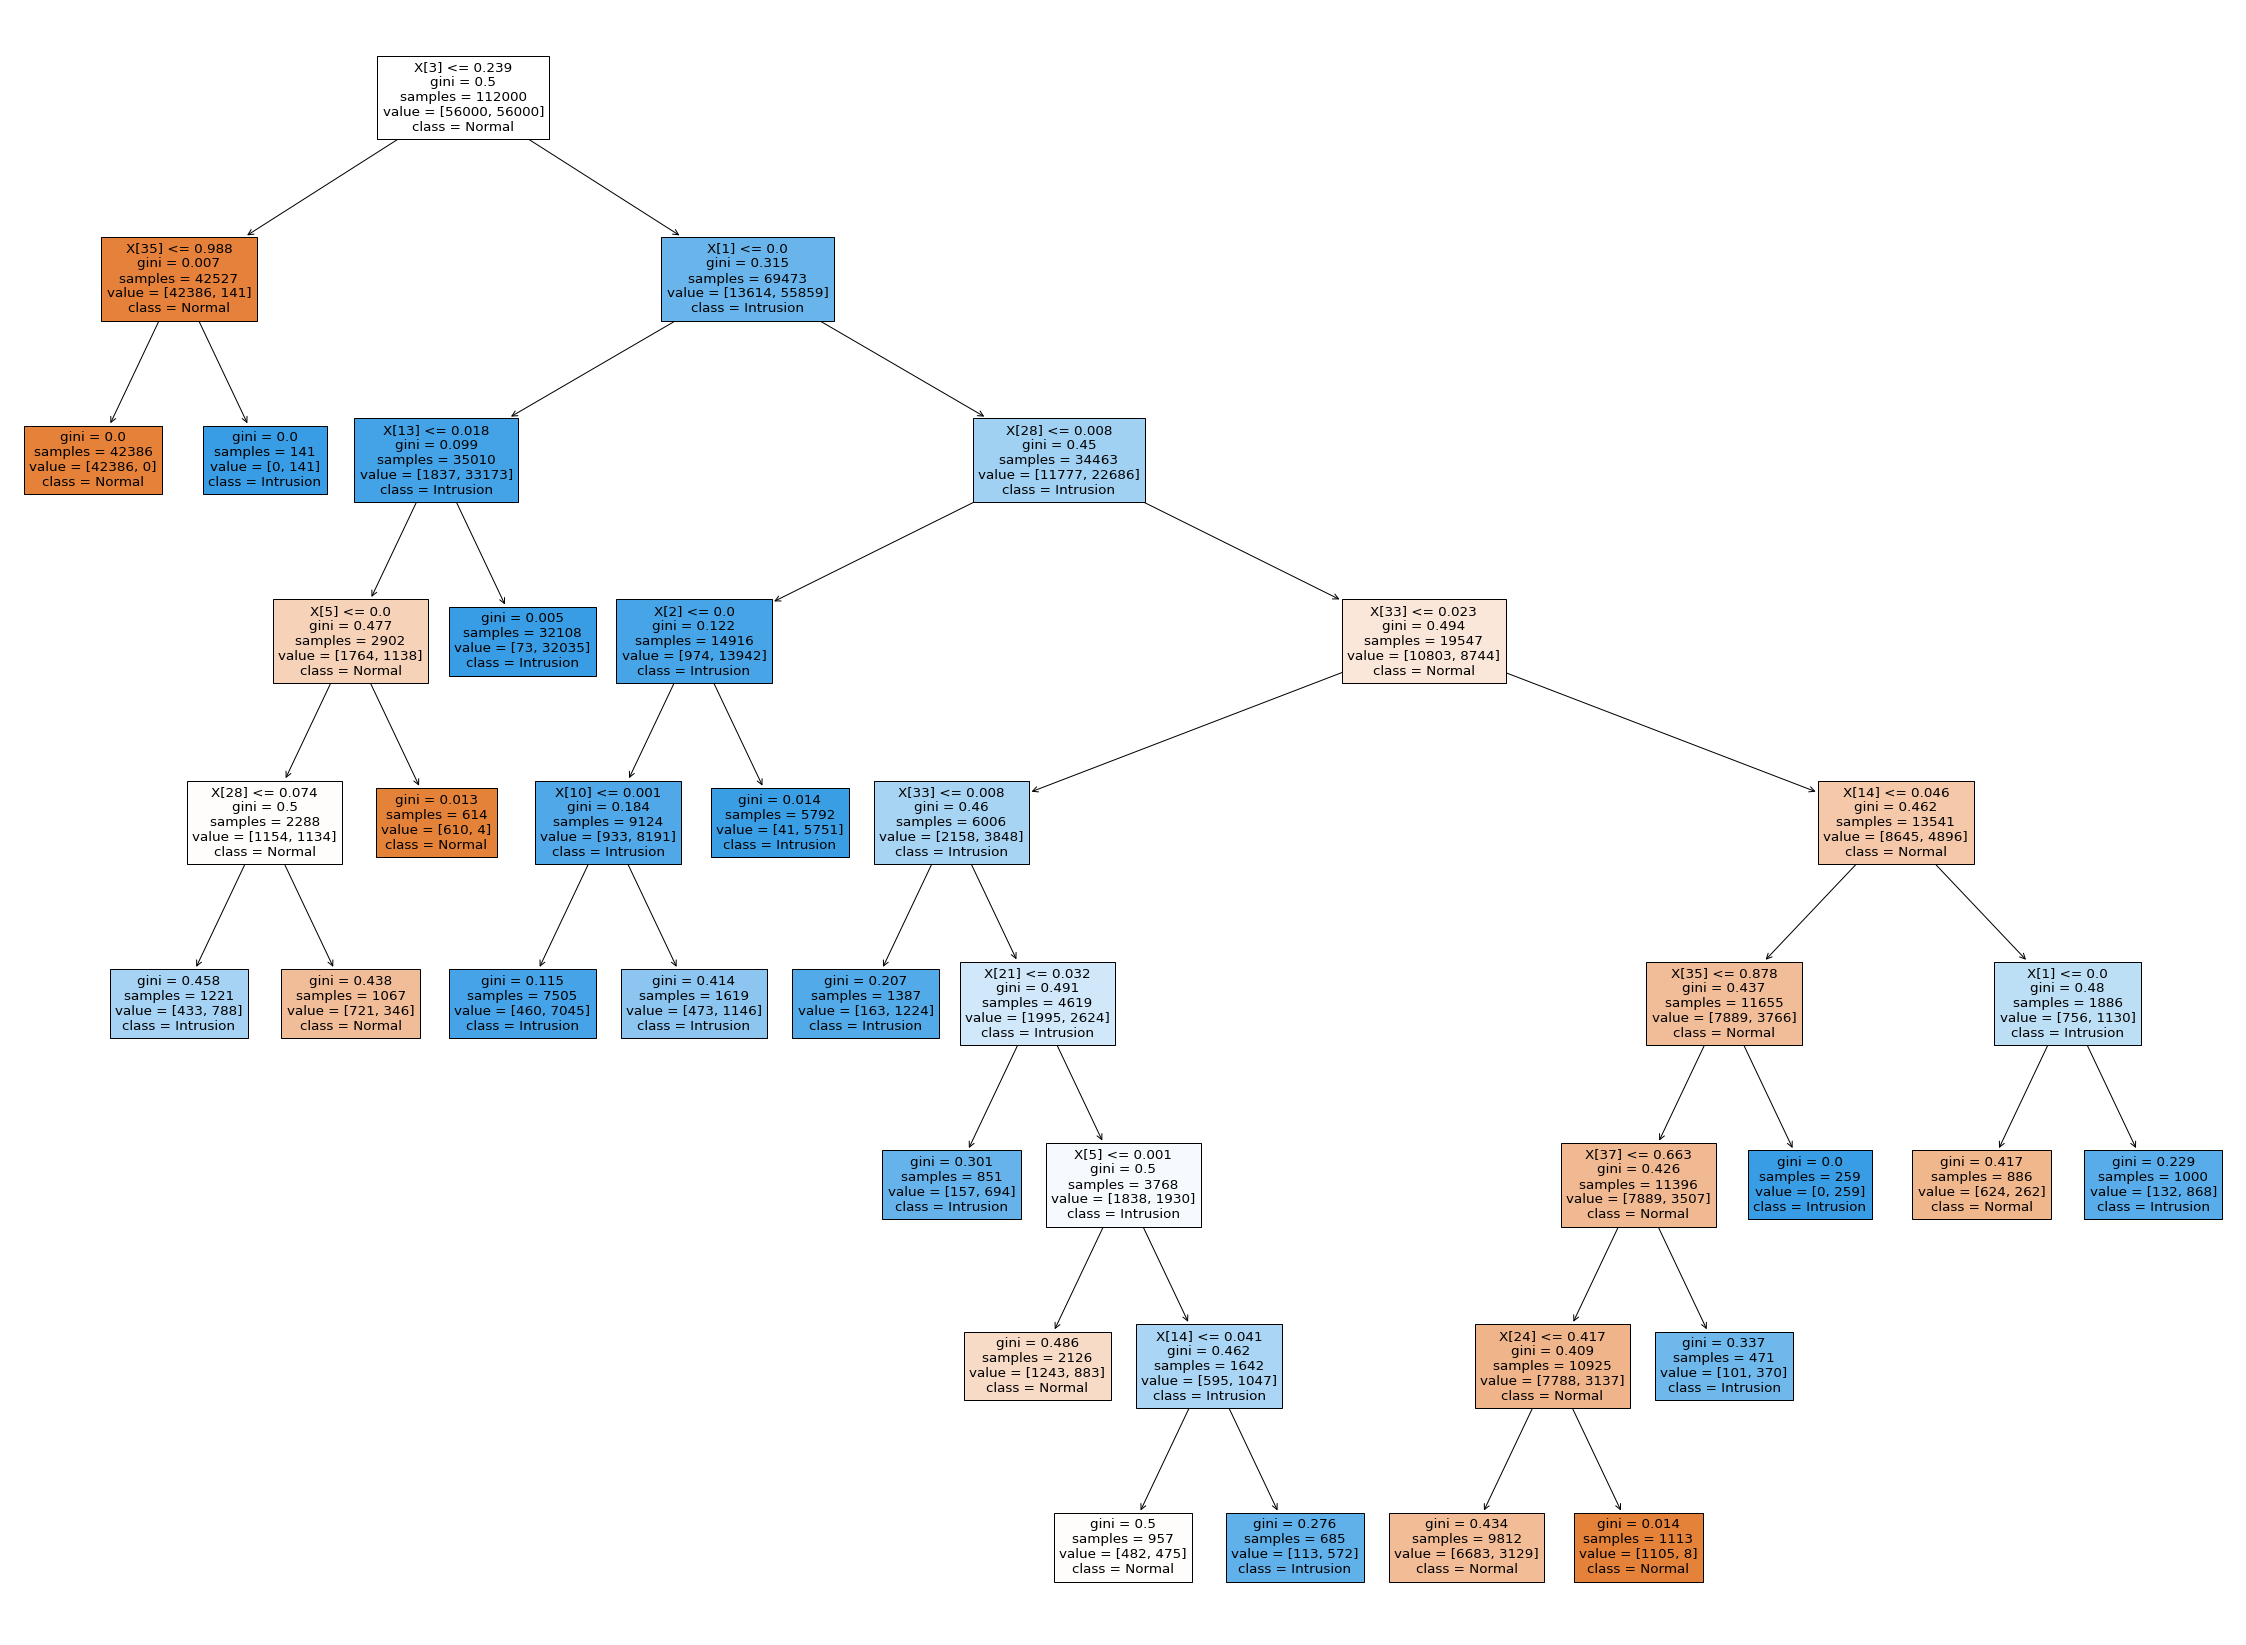

In [ ]:
fig = plt.figure(figsize=(40,30))
tree.plot_tree(binDT,filled=True, class_names= ['Normal', 'Intrusion'] )

In [ ]:
trainData, testData = get_data()

trainX = trainData[numerical_feat+categorical_feat]
testX = testData[numerical_feat + categorical_feat]
trainY = trainSet[['label']]
testY = testSet[['label']]

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, trainY = get_undersampling(trainX, trainY)

trainX, testX = min_max_scaling(trainX, testX)

binRF = RandomForestClassifier(class_weight = "balanced_subsample", max_depth=20,  ccp_alpha = 0.001 , n_estimators = 100, random_state=seed)
binRF.fit(trainX, trainY)
yhat = binRF.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))

print(classification_report(testY, yhat))

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Accuracy on Test Set: 0.913192926201234
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     37000
           1       0.89      0.96      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.92      0.91      0.91     82332
weighted avg       0.92      0.91      0.91     82332



KNN Classifier

In [ ]:

trainData, testData = get_data()

trainX = trainData[numerical_feat+categorical_feat]
testX = testData[numerical_feat + categorical_feat]
trainY = trainSet[['label']]
testY = testSet[['label']]

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, trainY = get_undersampling(trainX, trainY)

trainX, testX = min_max_scaling(trainX, testX)

binKNN = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=21)
binKNN.fit(trainX, trainY)
yhat = binKNN.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))

print(classification_report(testY, yhat))


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


Accuracy on Test Set: 0.8930185104212214
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     37000
           1       0.88      0.94      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.90      0.89      0.89     82332
weighted avg       0.89      0.89      0.89     82332



XGBoost


In [ ]:
trainData, testData = get_data()

trainX = trainData[numerical_feat+categorical_feat]
testX = testData[numerical_feat + categorical_feat]
trainY = trainSet[['label']]
testY = testSet[['label']]

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, trainY = get_undersampling(trainX, trainY)

trainX, testX = min_max_scaling(trainX, testX)
binXGB = xgb.XGBClassifier(colsample_bytree = 0.7,
                        learning_rate = 0.1,
                        min_child_weight = 11,
                        n_estimators = 100,
                        seed = 80,
                        silent = 1,
                        subsample = 0.8, random_state = seed)
binXGB.fit(trainX, trainY)
yhat = binXGB.predict(testX)
print(accuracy_score(testY, yhat))

print(classification_report(testY, yhat))


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.913338677549434
0.9408660714285715
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     37000
           1       0.90      0.95      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.92      0.91      0.91     82332
weighted avg       0.91      0.91      0.91     82332



Voting

In [ ]:
trainData, testData = get_data()

trainX = trainData[numerical_feat+categorical_feat]
testX = testData[numerical_feat + categorical_feat]
trainY = trainSet[['label']]
testY = testSet[['label']]

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, trainY = get_undersampling(trainX, trainY)

trainX, testX = min_max_scaling(trainX, testX)

clf1 = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=21)
clf2 = xgb.XGBClassifier(colsample_bytree = 0.7,
                        learning_rate = 0.1,
                        min_child_weight = 11,
                        n_estimators = 100,
                        seed = 80,
                        silent = 1,
                        subsample = 0.8, random_state = seed)
clf3 = DecisionTreeClassifier(max_depth=20, ccp_alpha = 0.0008, random_state=seed)
binVoting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')


binVoting.fit(trainX, trainY)

yhat = binVoting.predict(testX)
print(accuracy_score(testY, yhat))

print(classification_report(testY, yhat))

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

0.9142374775300005
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     37000
           1       0.89      0.96      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.92      0.91      0.91     82332
weighted avg       0.92      0.91      0.91     82332



###Multiclass Classification

Decision Tree

In [ ]:

trainData, testData = get_data("multi")
trainX = trainData[numerical_feat+categorical_feat]

testX = testData[numerical_feat + categorical_feat]

trainY = trainData['attack_cat']
testY = testData['attack_cat']

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)
trainX, trainY = get_undersampling(trainX, trainY, "tomek")

trainX, testX = min_max_scaling(trainX, testX)

multiDT = DecisionTreeClassifier(max_depth=20, random_state = seed, ccp_alpha = 0.0004)
multiDT.fit(trainX, trainY)
yhat = multiDT.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))
print(classification_report(testY, yhat))




/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7614779186707477
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     37000
           1       0.00      0.00      0.00       583
           2       0.00      0.00      0.00       677
           3       0.30      0.58      0.40      6062
           4       0.51      0.22      0.31       378
           5       0.84      0.80      0.82      3496
           6       0.52      0.92      0.66     11132
           7       0.00      0.00      0.00      4089
           8       0.00      0.00      0.00        44
           9       1.00      0.95      0.98     18871

    accuracy                           0.76     82332
   macro avg       0.41      0.42      0.40     82332
weighted avg       0.79      0.76      0.76     82332



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
trainData, testData = get_data("multi")

trainX = trainData[numerical_feat]
testX = testData[numerical_feat]
trainY = trainData['attack_cat']
testY = testData['attack_cat']
clf = xgb.XGBClassifier(colsample_bytree = 0.7,
                        learning_rate = 0.05,
                        max_depth = 20,
                        min_child_weight = 11,
                        n_estimators = 250,
                        seed = 1337,
                        silent = 1,
                        subsample = 0.8)
clf.fit( trainX, trainY )
y_pred = clf.predict( testX )
print( y_pred )
print("Accuracy score = ",accuracy_score(testY,y_pred))
print( classification_report(testY,y_pred) )
#print(confusion_matrix(testY,y_pred))

[3 3 3 ... 0 0 3]
Accuracy score =  0.7638949618617306
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     37000
           1       0.04      0.10      0.06       583
           2       0.02      0.03      0.02       677
           3       0.30      0.60      0.40      6062
           4       0.35      0.71      0.47       378
           5       0.92      0.80      0.86      3496
           6       0.62      0.84      0.71     11132
           7       0.50      0.14      0.22      4089
           8       0.81      0.39      0.52        44
           9       1.00      0.97      0.98     18871

    accuracy                           0.76     82332
   macro avg       0.55      0.53      0.51     82332
weighted avg       0.83      0.76      0.78     82332



[Text(1333.5284090909092, 1585.5, 'X[32] <= 0.078\ngini = 0.786\nsamples = 165200\nvalue = [53153, 1679, 1904, 15401, 758, 9837, 31125, 11415, 130\n39798]'),
 Text(880.3295454545455, 1494.9, 'X[3] <= 0.239\ngini = 0.734\nsamples = 125422\nvalue = [52958, 1599, 1758, 15065, 758, 9726, 30452, 10855, 130\n2121]'),
 Text(360.72727272727275, 1404.3, 'X[32] <= 0.033\ngini = 0.014\nsamples = 42614\nvalue = [42311, 15, 3, 15, 0, 24, 171, 72, 0, 3]'),
 Text(315.6363636363636, 1313.7, 'X[9] <= 0.0\ngini = 0.008\nsamples = 42467\nvalue = [42287, 9, 0, 9, 0, 12, 99, 51, 0, 0]'),
 Text(270.54545454545456, 1223.1, 'X[35] <= 0.46\ngini = 0.123\nsamples = 2797\nvalue = [2617, 9, 0, 9, 0, 12, 99, 51, 0, 0]'),
 Text(225.45454545454547, 1132.5, 'gini = 0.0\nsamples = 2617\nvalue = [2617, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(315.6363636363636, 1132.5, 'gini = 0.608\nsamples = 180\nvalue = [0, 9, 0, 9, 0, 12, 99, 51, 0, 0]'),
 Text(360.72727272727275, 1223.1, 'gini = 0.0\nsamples = 39670\nvalue = [39670, 0,

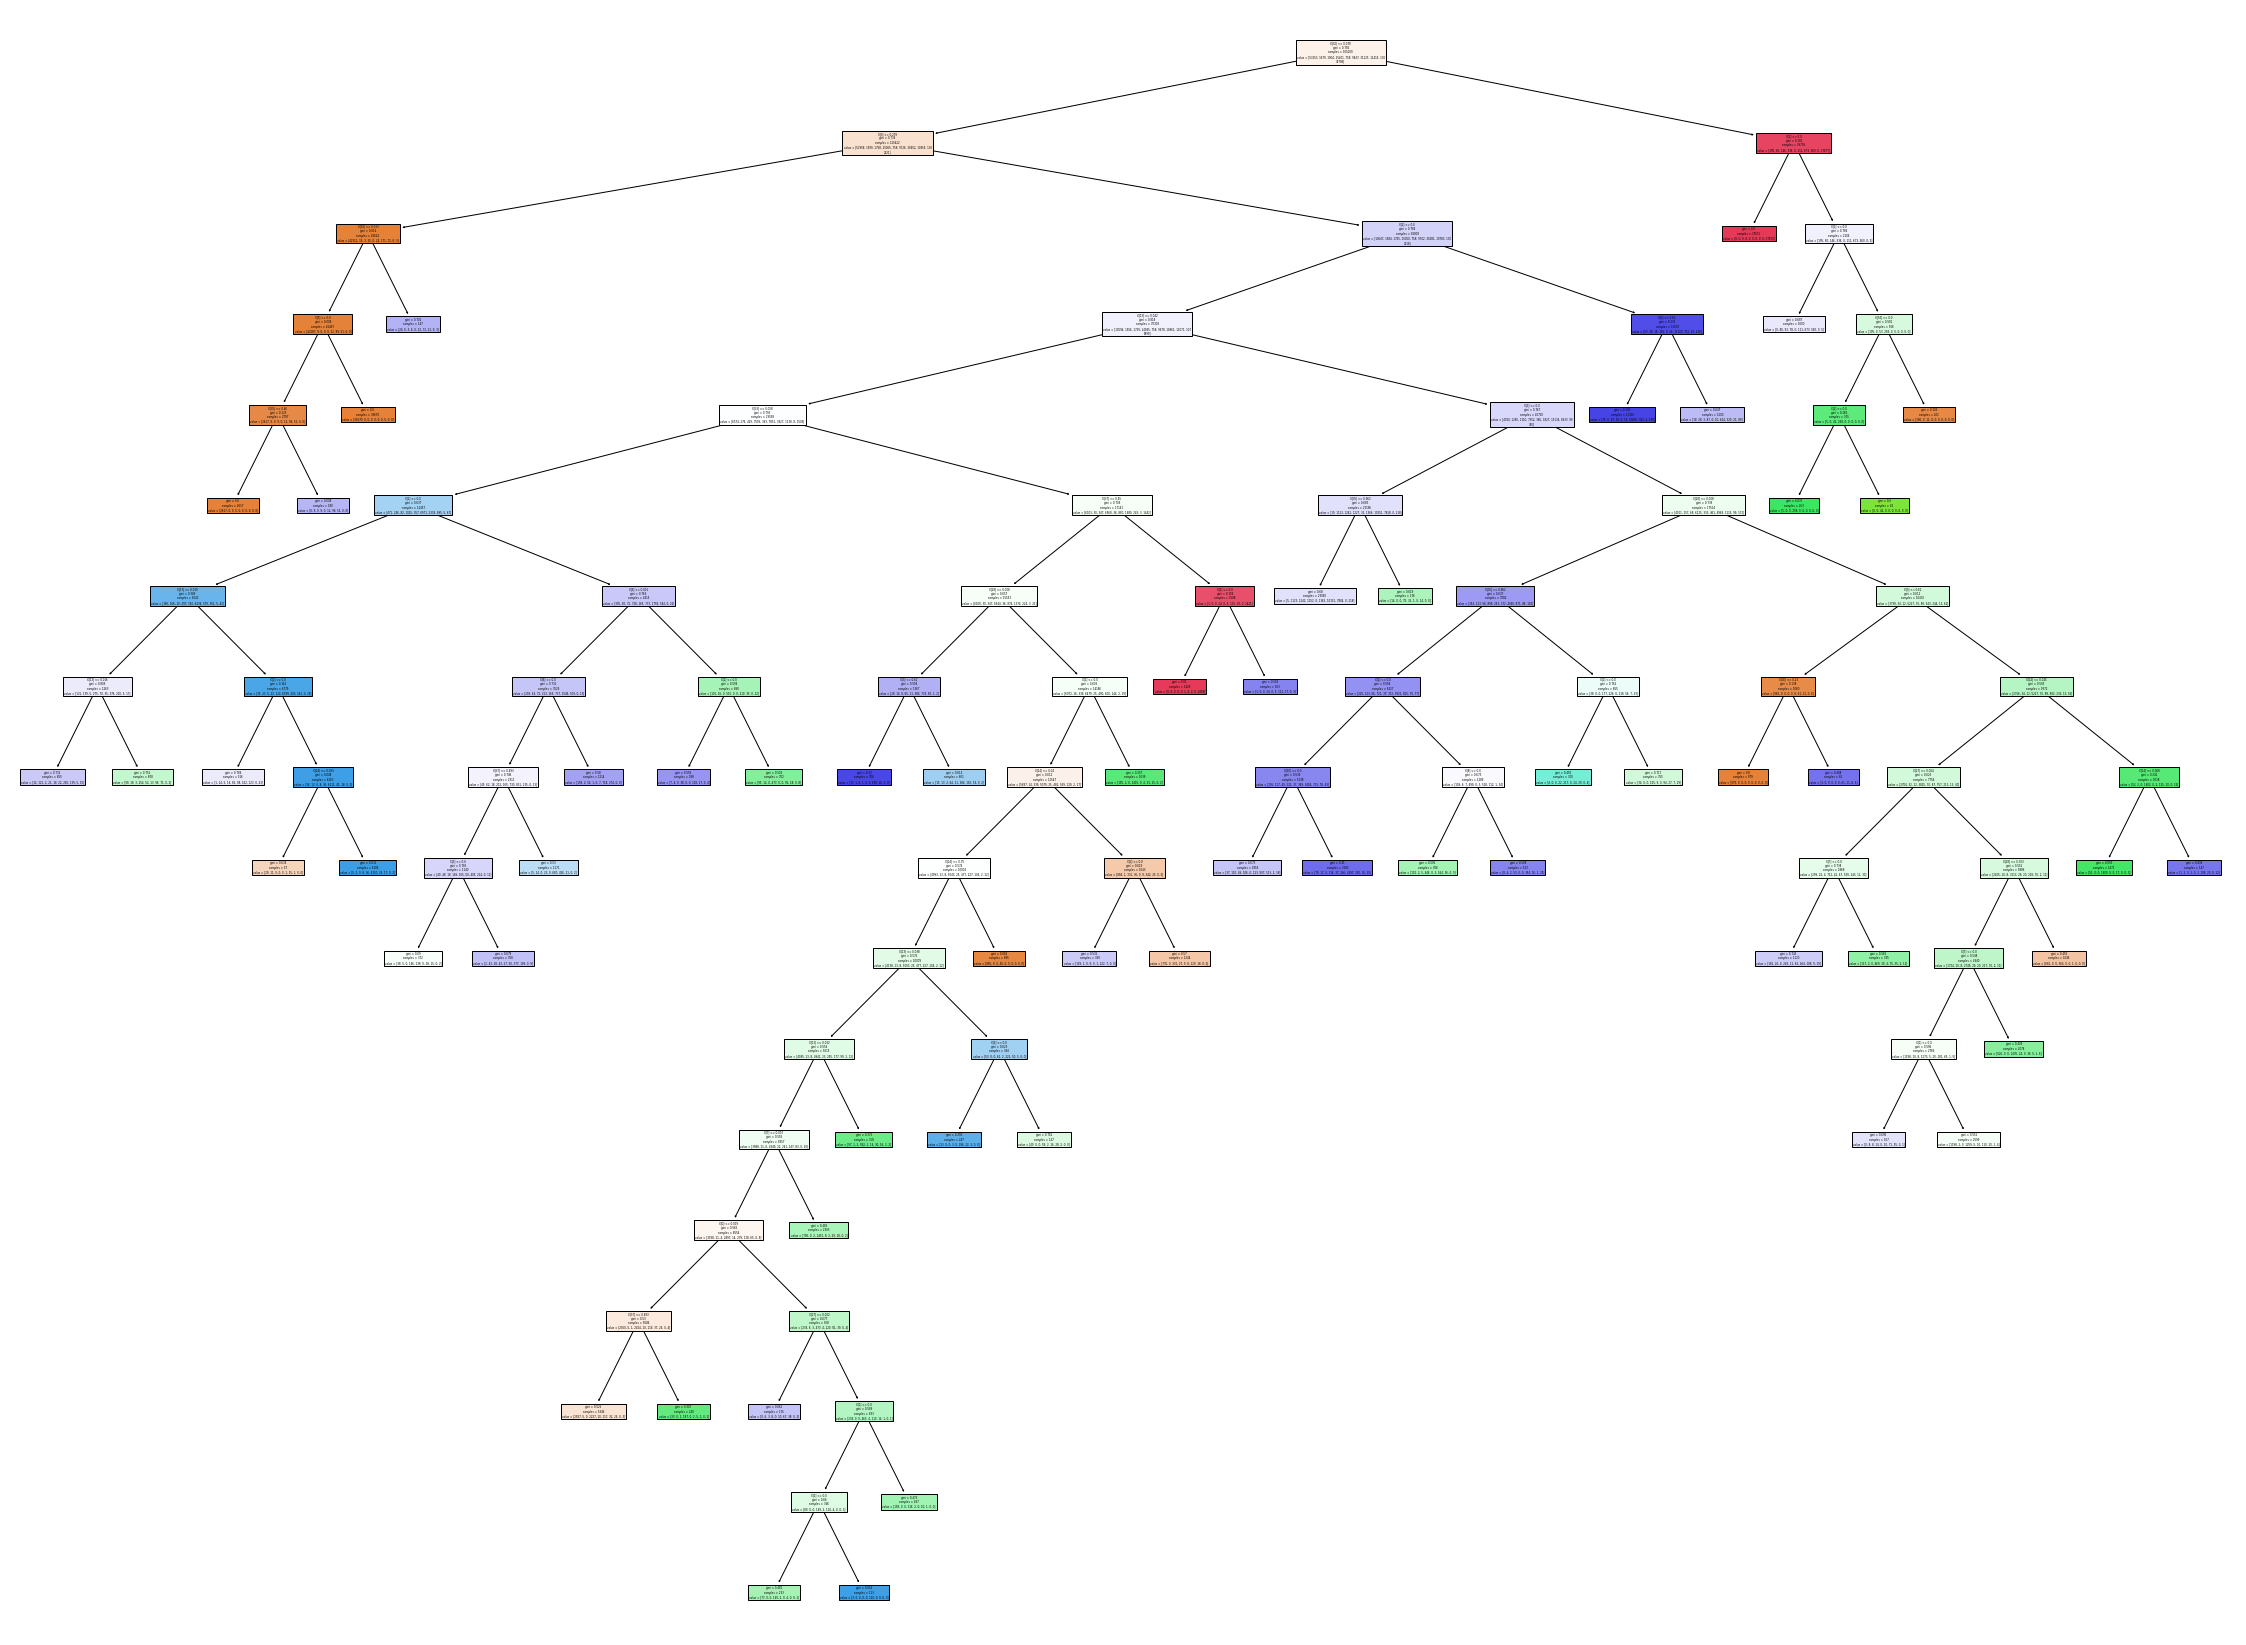

In [ ]:
fig = plt.figure(figsize=(40,30))
tree.plot_tree(clf1,filled=True)

Random Forest

In [ ]:

trainData, testData = get_data("multi")
trainX = trainData[numerical_feat+categorical_feat]

testX = testData[numerical_feat + categorical_feat]

trainY = trainData['attack_cat']
testY = testData['attack_cat']

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)
trainX, trainY = get_undersampling(trainX, trainY, "tomek")

trainX, testX = min_max_scaling(trainX, testX)

multiRF = RandomForestClassifier(class_weight = "balanced_subsample", n_estimators = 100, criterion="entropy", ccp_alpha= 0.000001, max_depth=40 , random_state=seed)
multiRF.fit(trainX, trainY)
yhat = multiRF.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))
print(classification_report(testY, yhat))


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy on Test Set: 0.7490161783996502
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     37000
           1       0.05      0.49      0.09       583
           2       0.02      0.04      0.03       677
           3       0.30      0.59      0.40      6062
           4       0.39      0.70      0.50       378
           5       0.93      0.80      0.86      3496
           6       0.74      0.67      0.71     11132
           7       0.35      0.22      0.28      4089
           8       0.62      0.55      0.58        44
           9       1.00      0.97      0.98     18871

    accuracy                           0.75     82332
   macro avg       0.54      0.58      0.53     82332
weighted avg       0.85      0.75      0.79     82332



KNN

In [ ]:

trainData, testData = get_data("multi")
trainX = trainData[numerical_feat+categorical_feat]

testX = testData[numerical_feat + categorical_feat]

trainY = trainData['attack_cat']
testY = testData['attack_cat']

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, testX = min_max_scaling(trainX, testX)

multiKNN = KNeighborsClassifier(weights='distance',  n_neighbors=16)
multiKNN.fit(trainX, trainY)
yhat = multiKNN.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))
print(classification_report(testY, yhat))




/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accuracy on Test Set: 0.7361536219210028
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     37000
           1       0.01      0.07      0.02       583
           2       0.00      0.00      0.00       677
           3       0.27      0.49      0.35      6062
           4       0.39      0.30      0.34       378
           5       0.59      0.76      0.67      3496
           6       0.63      0.73      0.68     11132
           7       0.32      0.12      0.18      4089
           8       0.41      0.16      0.23        44
           9       1.00      0.97      0.98     18871

    accuracy                           0.74     82332
   macro avg       0.46      0.44      0.43     82332
weighted avg       0.80      0.74      0.76     82332



Custom Model


In [ ]:

class myClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, secondModel):
       
        self.binary_tree = DecisionTreeClassifier(max_depth=20, ccp_alpha = 0.0008,random_state = seed)
        self.multi_tree = secondModel

    def fit(self, X, y):
        
        undersample = RandomUnderSampler(random_state = seed)
        idx = (y==0)
        # idx = idx.reshape(-1)
        yBin = np.copy(y)
        yBin[idx] = 0
        yBin[np.invert(idx)] = 1

        xBin, yBin = undersample.fit_resample(X, yBin)
        self.binary_tree.fit(xBin,yBin)


        yMulti = y[np.invert(idx)]
        xMulti = X[np.invert(idx)]

        undersample = TomekLinks(random_state = seed)
        xMulti, yMulti = undersample.fit_resample(xMulti, yMulti)
        self.multi_tree.fit(xMulti,yMulti)


    def predict(self, X):
        y1 = self.binary_tree.predict(X)
        idx = y1==1
        X2 = X[idx]
        y2 = self.multi_tree.predict(X2)
        y1[np.invert(idx)] = 0
        i = 0
        j = 0
        while (i<y1.shape[0]):
            if (y1[i]==0):
                y1[i] = 0
                i+=1
            else:
                y1[i] = y2[j]
                i+=1
                j+=1

        return y1


Decision Tree + Decision Tree




In [ ]:


trainData, testData = get_data("multi")
trainX = trainData[numerical_feat+categorical_feat]

testX = testData[numerical_feat + categorical_feat]

trainY = trainData['attack_cat']
testY = testData['attack_cat']

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, testX = min_max_scaling(trainX, testX)

multiDTDT = myClassifier(DecisionTreeClassifier(max_depth=20, random_state = seed, ccp_alpha = 0.0004))
multiDTDT.fit(trainX, trainY)
yhat = multiDTDT.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))
print(classification_report(testY, yhat))




/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy on Test Set: 0.8068430257979886
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     37000
           1       0.49      0.04      0.08       583
           2       0.00      0.00      0.00       677
           3       0.41      0.43      0.42      6062
           4       0.38      0.49      0.43       378
           5       0.87      0.80      0.83      3496
           6       0.53      0.91      0.67     11132
           7       0.36      0.00      0.01      4089
           8       0.00      0.00      0.00        44
           9       1.00      0.96      0.98     18871

    accuracy                           0.81     82332
   macro avg       0.50      0.45      0.43     82332
weighted avg       0.81      0.81      0.79     82332



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree + XGboost

In [ ]:
trainData, testData = get_data("multi")
trainX = trainData[numerical_feat+categorical_feat]

testX = testData[numerical_feat + categorical_feat]

trainY = trainData['attack_cat']
testY = testData['attack_cat']

get_categoryEncodedData(trainX, testX, categorical_feat, trainY)

trainX, testX = min_max_scaling(trainX, testX)

multiDTXGB = myClassifier(xgb.XGBClassifier(colsample_bytree = 0.7,
                        learning_rate = 0.1,
                        
                        min_child_weight = 11,
                        n_estimators = 100,
                        seed = 80,
                        silent = 1,
                        subsample = 0.8))
multiDTXGB.fit(trainX, trainY)
yhat = multiDTXGB.predict(testX)
print("Accuracy on Test Set:", accuracy_score(testY, yhat))
print(classification_report(testY, yhat))



/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy on Test Set: 0.813353252684254
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     37000
           1       0.64      0.03      0.06       583
           2       0.00      0.00      0.00       677
           3       0.43      0.48      0.45      6062
           4       0.41      0.56      0.48       378
           5       0.88      0.79      0.83      3496
           6       0.55      0.93      0.69     11132
           7       0.40      0.02      0.03      4089
           8       0.73      0.36      0.48        44
           9       1.00      0.96      0.98     18871

    accuracy                           0.81     82332
   macro avg       0.60      0.50      0.49     82332
weighted avg       0.82      0.81      0.80     82332



# KNN

## Binary Classification

In [ ]:
trainData, testData=get_data(dtype='binary')

In [ ]:
trainSet_filter_bin=trainData[["sttl", "sload", "dload", "swin" ,  "dwin", "dmean", "sinpkt", "ct_state_ttl", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm","attack_cat","label"]]
testSet_filter_bin=testData[["sttl", "sload", "dload", "swin" ,  "dwin", "dmean", "sinpkt", "ct_state_ttl", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm","attack_cat","label"]]
#scaling
minscaler = MinMaxScaler()
minscaler.fit(trainSet_filter_bin.drop(["attack_cat","label"],axis=1))
myX=minscaler.transform(trainSet_filter_bin.drop(["attack_cat","label"],axis=1))
myOtherX=minscaler.transform(testSet_filter_bin.drop(["attack_cat","label"],axis=1))

In [ ]:
clf = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=21)
clf.fit(myX, trainSet_filter_bin["label"])
print("Score on train data: ",clf.score(myX, trainSet_filter_bin["label"]))
print("Score on test data: ",clf.score(myOtherX, testSet_filter_bin["label"]))

Score on train data:  0.9979354514916648
Score on test data:  0.8276125929164845


In [ ]:
y_pred=clf.predict(myOtherX)
print(classification_report(testSet_filter_bin["label"], y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     37000
           1       0.80      0.92      0.85     45332

    accuracy                           0.83     82332
   macro avg       0.84      0.82      0.82     82332
weighted avg       0.83      0.83      0.82     82332



## Multiclass

In [ ]:
trainData, testData=get_data(dtype='multi')

In [ ]:
trainSet_wrapper_multiclass=trainData[['spkts', 'sbytes', 'sttl', 'dttl', 'sloss', 'swin', 'dwin', 'smean', 'trans_depth', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports',"attack_cat","label"]]
testSet_wrapper_multiclass=testData[['spkts', 'sbytes', 'sttl', 'dttl', 'sloss', 'swin', 'dwin', 'smean', 'trans_depth', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports',"attack_cat","label"]]

minscaler = MinMaxScaler()
minscaler.fit(trainSet_wrapper_multiclass.drop(["attack_cat","label"],axis=1).to_numpy(dtype='float'))
mymulX=minscaler.transform(trainSet_wrapper_multiclass.drop(["attack_cat","label"],axis=1).to_numpy(dtype='float'))
mymulOtherX=minscaler.transform(testSet_wrapper_multiclass.drop(["attack_cat","label"],axis=1).to_numpy(dtype='float'))



In [ ]:
clf2 = KNeighborsClassifier(weights='distance', n_neighbors=16)
clf2.fit(mymulX, trainSet_wrapper_multiclass["attack_cat"].to_numpy(dtype='float'));

In [ ]:
print("Score on train data: ",clf2.score(mymulX, trainSet_wrapper_multiclass["attack_cat"].to_numpy(dtype='float')))
print("Score on test data: ",clf2.score(mymulOtherX, testSet_wrapper_multiclass["attack_cat"].to_numpy(dtype='float')))

Score on train data:  0.8315282791817088
Score on test data:  0.7720813292522956


In [ ]:
y_pred2=clf2.predict(mymulOtherX)
print(classification_report(testSet_wrapper_multiclass["attack_cat"].to_numpy(dtype='float'), y_pred2, target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     37000
           1       0.15      0.04      0.07       583
           2       0.00      0.00      0.00       677
           3       0.32      0.49      0.39      6062
           4       0.41      0.76      0.53       378
           5       0.89      0.80      0.84      3496
           6       0.58      0.74      0.65     11132
           7       0.39      0.43      0.41      4089
           8       0.62      0.64      0.63        44
           9       0.99      0.98      0.98     18871

    accuracy                           0.77     82332
   macro avg       0.53      0.57      0.54     82332
weighted avg       0.80      0.77      0.78     82332

